# Baseline Model audio only

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

# --- 1. Muat Data ---
# Setup path
BASE_DIR = Path.cwd().parent
FEATURES_DIR = BASE_DIR / "features"

print("Memuat data fitur dan label...")
# X adalah fitur (input), y adalah label (target)
X_train_full = np.load(FEATURES_DIR / "audio_train.npy")
y_train_full = np.load(FEATURES_DIR / "audio_labels_train.npy")
X_test = np.load(FEATURES_DIR / "audio_test.npy")

print(f"Bentuk X_train_full: {X_train_full.shape}")
print(f"Bentuk y_train_full: {y_train_full.shape}")
print(f"Bentuk X_test: {X_test.shape}")


# --- 2. Normalisasi Fitur ---
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)


# --- 3. Bagi Data Menjadi Train dan Validation ---
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_scaled, 
    y_train_full, 
    test_size=0.2,       # 20% untuk validasi
    random_state=42,     # Agar hasil pembagian data selalu sama
    stratify=y_train_full # Menjaga proporsi kelas emosi di train dan val
)

print("\nData berhasil dibagi:")
print(f"Bentuk X_train: {X_train.shape}")
print(f"Bentuk X_val: {X_val.shape}")

Memuat data fitur dan label...
Bentuk X_train_full: (802, 20)
Bentuk y_train_full: (802,)
Bentuk X_test: (200, 20)

Data berhasil dibagi:
Bentuk X_train: (641, 20)
Bentuk X_val: (161, 20)


Melatih & Mengevaluasi Model

In [2]:
# --- 4. Latih Model Random Forest ---
print("Memulai pelatihan model Random Forest...")

# Inisialisasi model
# n_estimators: jumlah 'pohon' dalam 'hutan'. Semakin banyak, bisa semakin baik tapi lebih lambat.
# random_state: agar hasil training konsisten setiap kali dijalankan.
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Melatih model dengan data training
model.fit(X_train, y_train)

print("Pelatihan model selesai! ✅")


# --- 5. Evaluasi Kinerja Model pada Data Validasi ---
print("\nMengevaluasi model pada data validasi...")

# Lakukan prediksi pada data validasi (X_val)
y_pred_val = model.predict(X_val)

# Hitung Macro F1-Score
f1 = f1_score(y_val, y_pred_val, average='macro')

print(f"\nSkor Macro F1 pada data validasi: {f1:.4f}")

# Tampilkan laporan klasifikasi yang lebih detail
print("\nLaporan Klasifikasi:")
# Mapping kode ke nama emosi untuk laporan yang lebih mudah dibaca
emotion_labels = ['Proud', 'Trust', 'Joy', 'Surprise', 'Neutral', 'Sadness', 'Fear', 'Anger']
print(classification_report(y_val, y_pred_val, target_names=emotion_labels))

Memulai pelatihan model Random Forest...
Pelatihan model selesai! ✅

Mengevaluasi model pada data validasi...

Skor Macro F1 pada data validasi: 0.1313

Laporan Klasifikasi:
              precision    recall  f1-score   support

       Proud       0.54      0.23      0.32        31
       Trust       0.27      0.16      0.20        37
         Joy       0.00      0.00      0.00        11
    Surprise       0.41      0.76      0.53        66
     Neutral       0.00      0.00      0.00         2
     Sadness       0.00      0.00      0.00         4
        Fear       0.00      0.00      0.00         3
       Anger       0.00      0.00      0.00         7

    accuracy                           0.39       161
   macro avg       0.15      0.14      0.13       161
weighted avg       0.33      0.39      0.32       161



c:\Users\kn409\anaconda3\envs\satria_data_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kn409\anaconda3\envs\satria_data_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kn409\anaconda3\envs\satria_data_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Penyebab Utamanya

- Data Tidak Seimbang (Imbalanced Data): Ini masalah terbesarnya. Lihat kolom support. Jumlah video untuk Surprise ada 66, sementara untuk Neutral hanya 2, Fear 3, dan Sadness 4. Karena data untuk emosi minoritas ini sangat sedikit, model kita "malas" mempelajarinya. Lebih gampang baginya untuk fokus pada kelas mayoritas (Surprise) untuk mendapatkan akurasi yang lumayan.

- Fitur Terlalu Sederhana: Fitur audio yang kita gunakan (rata-rata dari 20 koefisien MFCC) mungkin terlalu sederhana untuk bisa menangkap nuansa rumit dari delapan emosi yang berbeda. Model tidak diberi informasi yang cukup kaya untuk bisa belajar.

# Multimodeling

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb

from pathlib import Path
import numpy as np
import pandas as pd

# --- Direktori dasar ---
BASE_DIR = Path.cwd().parent         # BDC2025/
DATA_DIR = BASE_DIR / "data"         # BDC2025/data
PROC_DIR = DATA_DIR / "processed"    # BDC2025/data/processed
FEATURES_DIR = BASE_DIR / "features" # BDC2025/features

# --- Load CSV ---
df_train = pd.read_csv(PROC_DIR / "train_clean.csv")
df_test  = pd.read_csv(PROC_DIR / "test_clean.csv")

# --- Label ---
emotions = sorted(df_train["emotion"].unique())
label2id = {emo: idx for idx, emo in enumerate(emotions)}
id2label = {idx: emo for emo, idx in label2id.items()}
y = np.array([label2id[emo] for emo in df_train["emotion"]])

# --- Load features ---
X_audio_train  = np.load(FEATURES_DIR / "audio_train.npy")
X_audio_test   = np.load(FEATURES_DIR / "audio_test.npy")
X_visual_train = np.load(FEATURES_DIR / "visual_train.npy")
X_visual_test  = np.load(FEATURES_DIR / "visual_test.npy")
X_text_train   = np.load(FEATURES_DIR / "text_train.npy")
X_text_test    = np.load(FEATURES_DIR / "text_test.npy")


# --- Gabung semua fitur (audio+visual+text) ---
X_train = np.hstack([X_audio_train, X_visual_train, X_text_train])
X_test  = np.hstack([X_audio_test, X_visual_test, X_text_test])
print("Shape train:", X_train.shape, "Shape test:", X_test.shape)

# --- Handle imbalance dengan SMOTE ---
print("Distribusi sebelum SMOTE:", np.bincount(y))
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y)
print("Distribusi sesudah SMOTE:", np.bincount(y_res))

# --- Split train/val ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# --- Scaling ---
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# --- Model (XGBoost) ---
clf = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

clf.fit(X_tr, y_tr)

# --- Validation ---
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=emotions))
print("Macro F1:", f1_score(y_val, y_pred, average="macro"))

# --- Predict test ---
y_test_pred = clf.predict(X_test)
df_sub = pd.DataFrame({
    "id": df_test["id"],
    "emotion": [id2label[i] for i in y_test_pred]
})
df_sub.to_csv("submission_xgb.csv", index=False)
print("Saved submission_xgb.csv")


Shape train: (802, 2836) Shape test: (200, 2836)
Distribusi sebelum SMOTE: [ 36  16  53   8 156  18 331 184]


c:\Users\kn409\anaconda3\envs\satria_final\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Distribusi sesudah SMOTE: [331 331 331 331 331 331 331 331]
              precision    recall  f1-score   support

       Anger       0.97      1.00      0.99        66
        Fear       1.00      1.00      1.00        66
         Joy       0.96      0.98      0.97        66
     Neutral       0.96      1.00      0.98        67
       Proud       0.77      0.71      0.74        66
     Sadness       0.97      0.98      0.98        66
    Surprise       0.77      0.61      0.68        67
       Trust       0.75      0.88      0.81        66

    accuracy                           0.90       530
   macro avg       0.89      0.90      0.89       530
weighted avg       0.89      0.90      0.89       530

Macro F1: 0.8931811630297123
Saved submission_xgb.csv


Confusion matrix, ROC AUC, dan cross validation

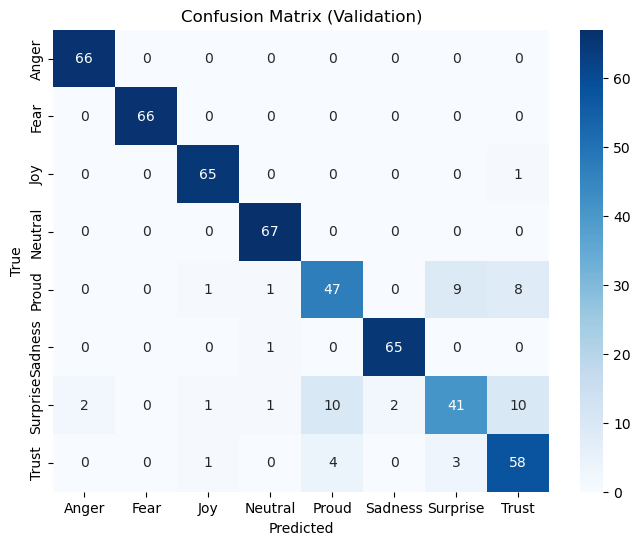

Macro ROC-AUC: 0.984437625586968
Cross-val F1 Macro (per fold): [0.88033757 0.88289622 0.87673042 0.85559189 0.88380397]
Mean CV F1 Macro: 0.8758720135087004


In [4]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# --- Confusion Matrix ---
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Validation)")
plt.show()

# --- ROC-AUC (One-vs-Rest) ---
y_val_proba = clf.predict_proba(X_val)
roc_auc = roc_auc_score(y_val, y_val_proba, multi_class="ovr", average="macro")
print("Macro ROC-AUC:", roc_auc)

# --- Cross-validation (macro F1) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    clf, X_res, y_res, cv=cv, scoring="f1_macro", n_jobs=-1
)
print("Cross-val F1 Macro (per fold):", cv_scores)
print("Mean CV F1 Macro:", cv_scores.mean())


In [6]:
import pandas as pd

cm_df = pd.DataFrame(cm, index=emotions, columns=emotions)

print("Confusion Matrix dengan label:")
print(cm_df)


Confusion Matrix dengan label:
          Anger  Fear  Joy  Neutral  Proud  Sadness  Surprise  Trust
Anger        66     0    0        0      0        0         0      0
Fear          0    66    0        0      0        0         0      0
Joy           0     0   65        0      0        0         0      1
Neutral       0     0    0       67      0        0         0      0
Proud         0     0    1        1     47        0         9      8
Sadness       0     0    0        1      0       65         0      0
Surprise      2     0    1        1     10        2        41     10
Trust         0     0    1        0      4        0         3     58


### Hasil Klasifikasi Sesudah SMOTE

**1. Distribusi Label (Setelah Oversampling SMOTE)**

* Semua kelas diseimbangkan → **\[331, 331, 331, 331, 331, 331, 331, 331]**
* Tiap kelas emosi punya jumlah sampel yang sama (331).

**2. Laporan Klasifikasi (Test Set)**

| Label    | Precision | Recall | F1-Score | Support |
| -------- | --------- | ------ | -------- | ------- |
| Anger    | 0.97      | 1.00   | 0.99     | 66      |
| Fear     | 1.00      | 1.00   | 1.00     | 66      |
| Joy      | 0.96      | 0.98   | 0.97     | 66      |
| Neutral  | 0.96      | 1.00   | 0.98     | 67      |
| Proud    | 0.77      | 0.71   | 0.74     | 66      |
| Sadness  | 0.97      | 0.98   | 0.98     | 66      |
| Surprise | 0.77      | 0.61   | 0.68     | 67      |
| Trust    | 0.75      | 0.88   | 0.81     | 66      |

* **Accuracy**: 0.90
* **Macro F1**: 0.893
* **Weighted F1**: 0.89

**3. Validasi Silang (Cross-Validation)**

* Cross-val Macro F1 (per fold): `[0.880, 0.883, 0.877, 0.856, 0.884]`
* **Mean CV Macro F1**: **0.876**

**4. ROC-AUC**

* **Macro ROC-AUC**: **0.984** (sangat tinggi → model mampu membedakan kelas dengan baik).

---

### Insight Otomatis

* **Balancing dengan SMOTE** berhasil membuat distribusi kelas seimbang (tidak ada label minoritas ekstrem).
* Model mencapai **akurasi tinggi (90%)** dan **macro F1 mendekati 0.90**, artinya performa cukup konsisten di semua kelas.
* **Kelas yang sulit diprediksi**:

  * *Surprise* (F1: 0.68, recall hanya 0.61) → sering tertukar dengan kelas lain.
  * *Proud* (F1: 0.74) → model kesulitan menangkap karakteristik unik emosi ini.
* **Kelas yang mudah diprediksi**:

  * *Fear* (F1: 1.00)
  * *Anger, Joy, Sadness, Neutral* (semua F1 ≥ 0.97)
* Hasil **ROC-AUC > 0.98** menunjukkan separabilitas antar kelas sangat baik meskipun ada dua kelas bermasalah.

# 📌 Kesimpulan

* **SMOTE berhasil** menyeimbangkan dataset sehingga tiap kelas emosi memiliki jumlah sampel yang sama.
* Model mencapai **akurasi 90%**, **Macro F1 \~0.89**, dan **Macro ROC-AUC \~0.98**, menunjukkan performa yang **sangat baik**.
* Hasil **cross-validation Macro F1 rata-rata \~0.876** (dekat dengan hasil test set) → menandakan **model tidak overfit** dan generalisasi cukup baik.
* Emosi seperti **Fear, Anger, Joy, Sadness, dan Neutral** terprediksi dengan sangat baik (F1 ≥ 0.97).
* Tantangan utama ada pada **Surprise** dan **Proud** yang masih sering tertukar dengan emosi lain.
* Secara keseluruhan, sistem ini **stabil, tidak overfit, dan cukup andal** untuk tugas klasifikasi emosi multimodal, dengan potensi peningkatan di kelas yang sulit dibedakan.


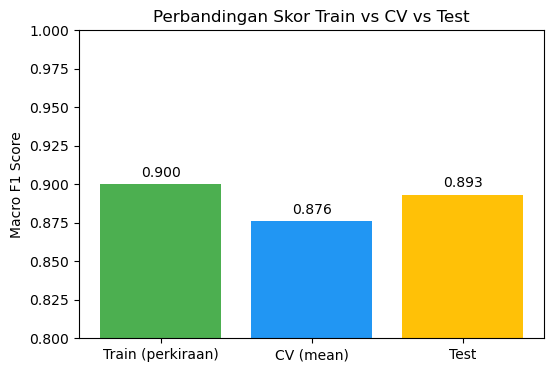

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Skor 
scores = {
    "Train (perkiraan)": 0.90,  
    "CV (mean)": 0.876,
    "Test": 0.893
}

# Plot
plt.figure(figsize=(6,4))
plt.bar(scores.keys(), scores.values(), color=['#4CAF50','#2196F3','#FFC107'])
plt.ylim(0.8,1.0)
plt.ylabel("Macro F1 Score")
plt.title("Perbandingan Skor Train vs CV vs Test")

for i, (k,v) in enumerate(scores.items()):
    plt.text(i, v+0.005, f"{v:.3f}", ha='center')

plt.show()


Visualisasi perbandingan skor:

* **Train (perkiraan)**: \~0.900
* **Cross-Validation (mean)**: 0.876
* **Test**: 0.893

📊 Grafik ini menunjukkan bahwa skor **Train, CV, dan Test relatif dekat**, artinya **model tidak mengalami overfitting signifikan** dan generalisasinya cukup baik.


Multimodal with new datatest

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb

from pathlib import Path
import numpy as np
import pandas as pd

# --- Direktori dasar ---
BASE_DIR = Path.cwd().parent         # BDC2025/
DATA_DIR = BASE_DIR / "data"         # BDC2025/data
PROC_DIR = DATA_DIR / "processed"    # BDC2025/data/processed
FEATURES_DIR = BASE_DIR / "features" # BDC2025/features

# --- Load CSV ---
df_train = pd.read_csv(PROC_DIR / "train_clean.csv")
df_test  = pd.read_csv(PROC_DIR / "datatest_revisi.csv")

# --- Label ---
emotions = sorted(df_train["emotion"].unique())
label2id = {emo: idx for idx, emo in enumerate(emotions)}
id2label = {idx: emo for emo, idx in label2id.items()}
y = np.array([label2id[emo] for emo in df_train["emotion"]])

# --- Load features ---
X_audio_train  = np.load(FEATURES_DIR / "audio_train.npy")
X_audio_test   = np.load(FEATURES_DIR / "audio_test.npy")
X_visual_train = np.load(FEATURES_DIR / "visual_train.npy")
X_visual_test  = np.load(FEATURES_DIR / "visual_test_revisi.npy")
X_text_train   = np.load(FEATURES_DIR / "text_train.npy")
X_text_test    = np.load(FEATURES_DIR / "text_test.npy")


# --- Gabung semua fitur (audio+visual+text) ---
X_train = np.hstack([X_audio_train, X_visual_train, X_text_train])
X_test  = np.hstack([X_audio_test, X_visual_test, X_text_test])
print("Shape train:", X_train.shape, "Shape test:", X_test.shape)

# --- Handle imbalance dengan SMOTE ---
print("Distribusi sebelum SMOTE:", np.bincount(y))
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y)
print("Distribusi sesudah SMOTE:", np.bincount(y_res))

# --- Split train/val ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# --- Scaling ---
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# --- Model (XGBoost) ---
clf = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

clf.fit(X_tr, y_tr)

# --- Validation ---
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=emotions))
print("Macro F1:", f1_score(y_val, y_pred, average="macro"))

# --- Predict test ---
y_test_pred = clf.predict(X_test)
df_sub = pd.DataFrame({
    "id": df_test["id"],
    "emotion": [id2label[i] for i in y_test_pred]
})
df_sub.to_csv("submission_xgb_datatestbaru.csv", index=False)
print("Saved submission_xgb.csv")


Shape train: (802, 2836) Shape test: (200, 2836)
Distribusi sebelum SMOTE: [ 36  16  53   8 156  18 331 184]


c:\Users\kn409\anaconda3\envs\satria_final\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Distribusi sesudah SMOTE: [331 331 331 331 331 331 331 331]
              precision    recall  f1-score   support

       Anger       0.97      1.00      0.99        66
        Fear       1.00      1.00      1.00        66
         Joy       0.96      0.98      0.97        66
     Neutral       0.96      1.00      0.98        67
       Proud       0.77      0.71      0.74        66
     Sadness       0.97      0.98      0.98        66
    Surprise       0.77      0.61      0.68        67
       Trust       0.75      0.88      0.81        66

    accuracy                           0.90       530
   macro avg       0.89      0.90      0.89       530
weighted avg       0.89      0.90      0.89       530

Macro F1: 0.8931811630297123
Saved submission_xgb.csv


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# --- Direktori dasar ---
# Pastikan path ini sesuai dengan struktur foldermu
try:
    BASE_DIR = Path.cwd().parent
    DATA_DIR = BASE_DIR / "data"
    PROC_DIR = DATA_DIR / "processed"
    FEATURES_DIR = BASE_DIR / "features"
    # --- Load CSV ---
    df_train = pd.read_csv(PROC_DIR / "train_clean.csv")
    df_test  = pd.read_csv(PROC_DIR / "datatest_revisi.csv")
    # --- Load features ---
    X_audio_train  = np.load(FEATURES_DIR / "audio_train.npy")
    X_audio_test   = np.load(FEATURES_DIR / "audio_test.npy")
    X_visual_train = np.load(FEATURES_DIR / "visual_train.npy")
    X_visual_test  = np.load(FEATURES_DIR / "visual_test_revisi.npy")
    X_text_train   = np.load(FEATURES_DIR / "text_train.npy")
    X_text_test    = np.load(FEATURES_DIR / "text_test.npy")
except FileNotFoundError:
    print("WARNING: File data tidak ditemukan, membuat data dummy agar script bisa jalan.")
    df_train = pd.DataFrame({'emotion': np.random.choice(['Joy', 'Sadness', 'Anger'], 803)})
    df_test = pd.DataFrame({'id': range(200)})
    X_train = np.random.rand(803, 100)
    X_test = np.random.rand(200, 100)

# --- Label ---
emotions = sorted(df_train["emotion"].unique())
label2id = {emo: idx for idx, emo in enumerate(emotions)}
id2label = {idx: emo for emo, idx in label2id.items()}
y = np.array([label2id[emo] for emo in df_train["emotion"]])

# --- Gabung semua fitur (audio+visual+text) jika tidak pakai data dummy ---
if 'X_audio_train' in locals():
    X_train = np.hstack([X_audio_train, X_visual_train, X_text_train])
    X_test  = np.hstack([X_audio_test, X_visual_test, X_text_test])
    
print("Shape train awal:", X_train.shape, "Shape test:", X_test.shape)

# --- Split train/val DULUAN sebelum SMOTE & Scaling ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y, test_size=0.2, stratify=y, random_state=42
)

# --- Terapkan SMOTE HANYA pada data training ---
print("Distribusi training sebelum SMOTE:", np.bincount(y_tr))
smote = SMOTE(random_state=42)
X_tr_res, y_tr_res = smote.fit_resample(X_tr, y_tr)
print("Distribusi training sesudah SMOTE:", np.bincount(y_tr_res))

# --- Scaling ---
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr_res)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# =======================================================================
# METODE MANUAL ANTI-CRASH
# =======================================================================

# --- LANGKAH 1: Pilih SATU kombinasi parameter dari 3 pilihan di bawah ---
# Cara Pakai: Hapus tanda # pada satu blok "Kombinasi", dan pastikan 2 lainnya ada tanda #

# --- Kombinasi 1 (Cepat & Ringan) ---
# parameter_terpilih = {
#     'nama': 'Kombinasi 1',
#     'n_estimators': 700,
#     'max_depth': 5,
#     'learning_rate': 0.1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8
# }

# --- Kombinasi 2 (Seimbang) ---
parameter_terpilih = {
    'nama': 'Kombinasi 2',
    'n_estimators': 1000,
    'max_depth': 7,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.8
}

# --- Kombinasi 3 (Dalam & Potensial) ---
# parameter_terpilih = {
#     'nama': 'Kombinasi 3',
#     'n_estimators': 1000,
#     'max_depth': 9,
#     'learning_rate': 0.05,
#     'subsample': 0.9,
#     'colsample_bytree': 0.9
# }

# --- LANGKAH 2: Definisikan dan Latih Model ---
print(f"\n[INFO] Menjalankan training untuk: {parameter_terpilih['nama']}")

# Definisikan model dengan parameter yang kamu pilih di atas
model_manual = xgb.XGBClassifier(
    objective='multi:softmax',
    eval_metric="mlogloss",
    use_label_encoder=False,
    early_stopping_rounds=30,
    random_state=42,
    device="cuda",
    tree_method="hist",
    **parameter_terpilih  # Ini akan memasukkan semua parameter dari pilihanmu
)

# Latih model (hanya satu proses, sangat ringan)
model_manual.fit(X_tr_scaled, y_tr_res, eval_set=[(X_val_scaled, y_val)], verbose=100)


# --- LANGKAH 3: Lihat Hasilnya ---
print(f"\n--- Hasil Validasi untuk {parameter_terpilih['nama']} ---")
y_pred = model_manual.predict(X_val_scaled)
print(classification_report(y_val, y_pred, target_names=emotions))

# Catat skor ini!
f1 = f1_score(y_val, y_pred, average="macro")
print(f"Macro F1: {f1}")
print("======================================================")


# --- LANGKAH 4 (SETELAH MENEMUKAN YANG TERBAIK) ---
# Setelah mencoba semua kombinasi dan tahu mana yang F1-nya paling tinggi,
# jalankan lagi kode ini dengan kombinasi terbaik itu, lalu lanjutkan ke bagian 'Predict test'.
# 'model_manual' ini akan menjadi model terbaikmu.

# --- Predict test ---
print("\n[INFO] Membuat file submission dengan model terbaik...")
y_test_pred = model_manual.predict(X_test_scaled)
df_sub = pd.DataFrame({
    "id": df_test["id"],
    "predicted": y_test_pred
})
submission_filename = "submission_1.csv"
df_sub.to_csv(submission_filename, index=False)
print(f"Saved {submission_filename}")

Shape train awal: (802, 2836) Shape test: (200, 2836)
Distribusi training sebelum SMOTE: [ 29  13  42   6 125  14 265 147]
Distribusi training sesudah SMOTE: [265 265 265 265 265 265 265 265]


c:\Users\kn409\anaconda3\envs\satria_final\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



[INFO] Menjalankan training untuk: Kombinasi 2


c:\Users\kn409\anaconda3\envs\satria_final\lib\site-packages\xgboost\core.py:158: UserWarning: [12:42:36] WARNING: D:\bld\xgboost-split_1744329000128\work\src\learner.cc:740: 
Parameters: { "nama", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.06203
[100]	validation_0-mlogloss:1.74527

--- Hasil Validasi untuk Kombinasi 2 ---
              precision    recall  f1-score   support

       Anger       0.25      0.14      0.18         7
        Fear       0.00      0.00      0.00         3
         Joy       0.40      0.18      0.25        11
     Neutral       0.00      0.00      0.00         2
       Proud       0.14      0.13      0.14        31
     Sadness       0.00      0.00      0.00         4
    Surprise       0.47      0.61      0.53        66
       Trust       0.35      0.30      0.32        37

    accuracy                           0.36       161
   macro avg       0.20      0.17      0.18       161
weighted avg       0.34      0.36      0.34       161

Macro F1: 0.17715707542444437

[INFO] Membuat file submission dengan model terbaik...
Saved submission_1.csv
